In [19]:
import pandas as pd, json
import numpy as np
import matplotlib.pyplot as plt
from ipdb import set_trace
from statsmodels.regression import linear_model
from scipy import stats

### Data processing functions

In [20]:
cubic_num = range(1, 34, 4)
bbr_num = range(1, 34, 4)
queues = [0.25, 0.5, 1, 4, 8, 16, 32]
loss_rate = [1, 2, 5, 10, 20, 50]
times = [60, 60, 60, 60, 60, 100, 200]
tcp_size = 60 * 8 # bits
bw = 10000000 / tcp_size # packets per second
rtt = 0.04 # seconds

def get_bps(bdp, bbr_num, loss_num, bbr=True, lr=0):
    f = open(f"./iperf3_results/all_{bdp}/{'bbr' if bbr else 'cubic'}_{bdp}_{bbr_num}_{loss_num}_10_40.json")
    data = json.load(f)
    if not 'sum_sent' in data['end']: # guard for bad data (timed out too soon in data_collector)
        return -1
    bps = data['end']['sum_sent']['bits_per_second']
    
    return bps

def get_loss_bps(bdp, bbr_num, loss_num, bbr=True, lr=0):
    f = open(f"./iperf3_results/all_loss_{lr}/{'bbr' if bbr else 'cubic'}_{bdp}_{bbr_num}_{loss_num}_10_40.json")
    data = json.load(f)
    if not 'sum_sent' in data['end']: # guard for bad data (timed out too soon in data_collector)
        return -1
    bps = data['end']['sum_sent']['bits_per_second']
    
    return bps

'''
    c: packets per milisecond
    l: miliseconds
    X: # of BDP 
    N: # of BBR
    d: duration after convergence
'''
def get_model_rates(N, c, l, X, d):
    
    q = X * c * l/2
    p = 0.5 - 1.0/(2*X) - 4.0*N/q
    p_t = (q/c + 0.2*l) * d/10
    bbr_frac = (1-p) * (d-p_t) / d
#     set_trace()
    return min(1, bbr_frac)


def get_rates(bbr_num, loss_num, duration=1, isModel=False):
    rates = []
    for q in queues:
        if isModel:
            frac = get_model_rates(bbr_num, bw, rtt, q, duration)
            rates.append(frac)
        else:
            b_rate, l_rate = get_bps(q, bbr_num, 1, True), get_bps(q, bbr_num, 1, False)
            rates.append(b_rate / (b_rate + l_rate))
    
    return rates


def get_rates_loss(bbr_num, loss_num, duration=1, isModel=False):
    rates = []
    for lr in loss_rate:
        b_rate, l_rate = get_loss_bps(4, bbr_num, loss_num, True, lr=lr), get_bps(4, bbr_num, loss_num, False, lr=lr)
        rates.append(b_rate / (b_rate + l_rate))
    

    return rates


# EXP1
### plot validation curves

/tmp/ipykernel_23368/303459691.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([0] + queues)


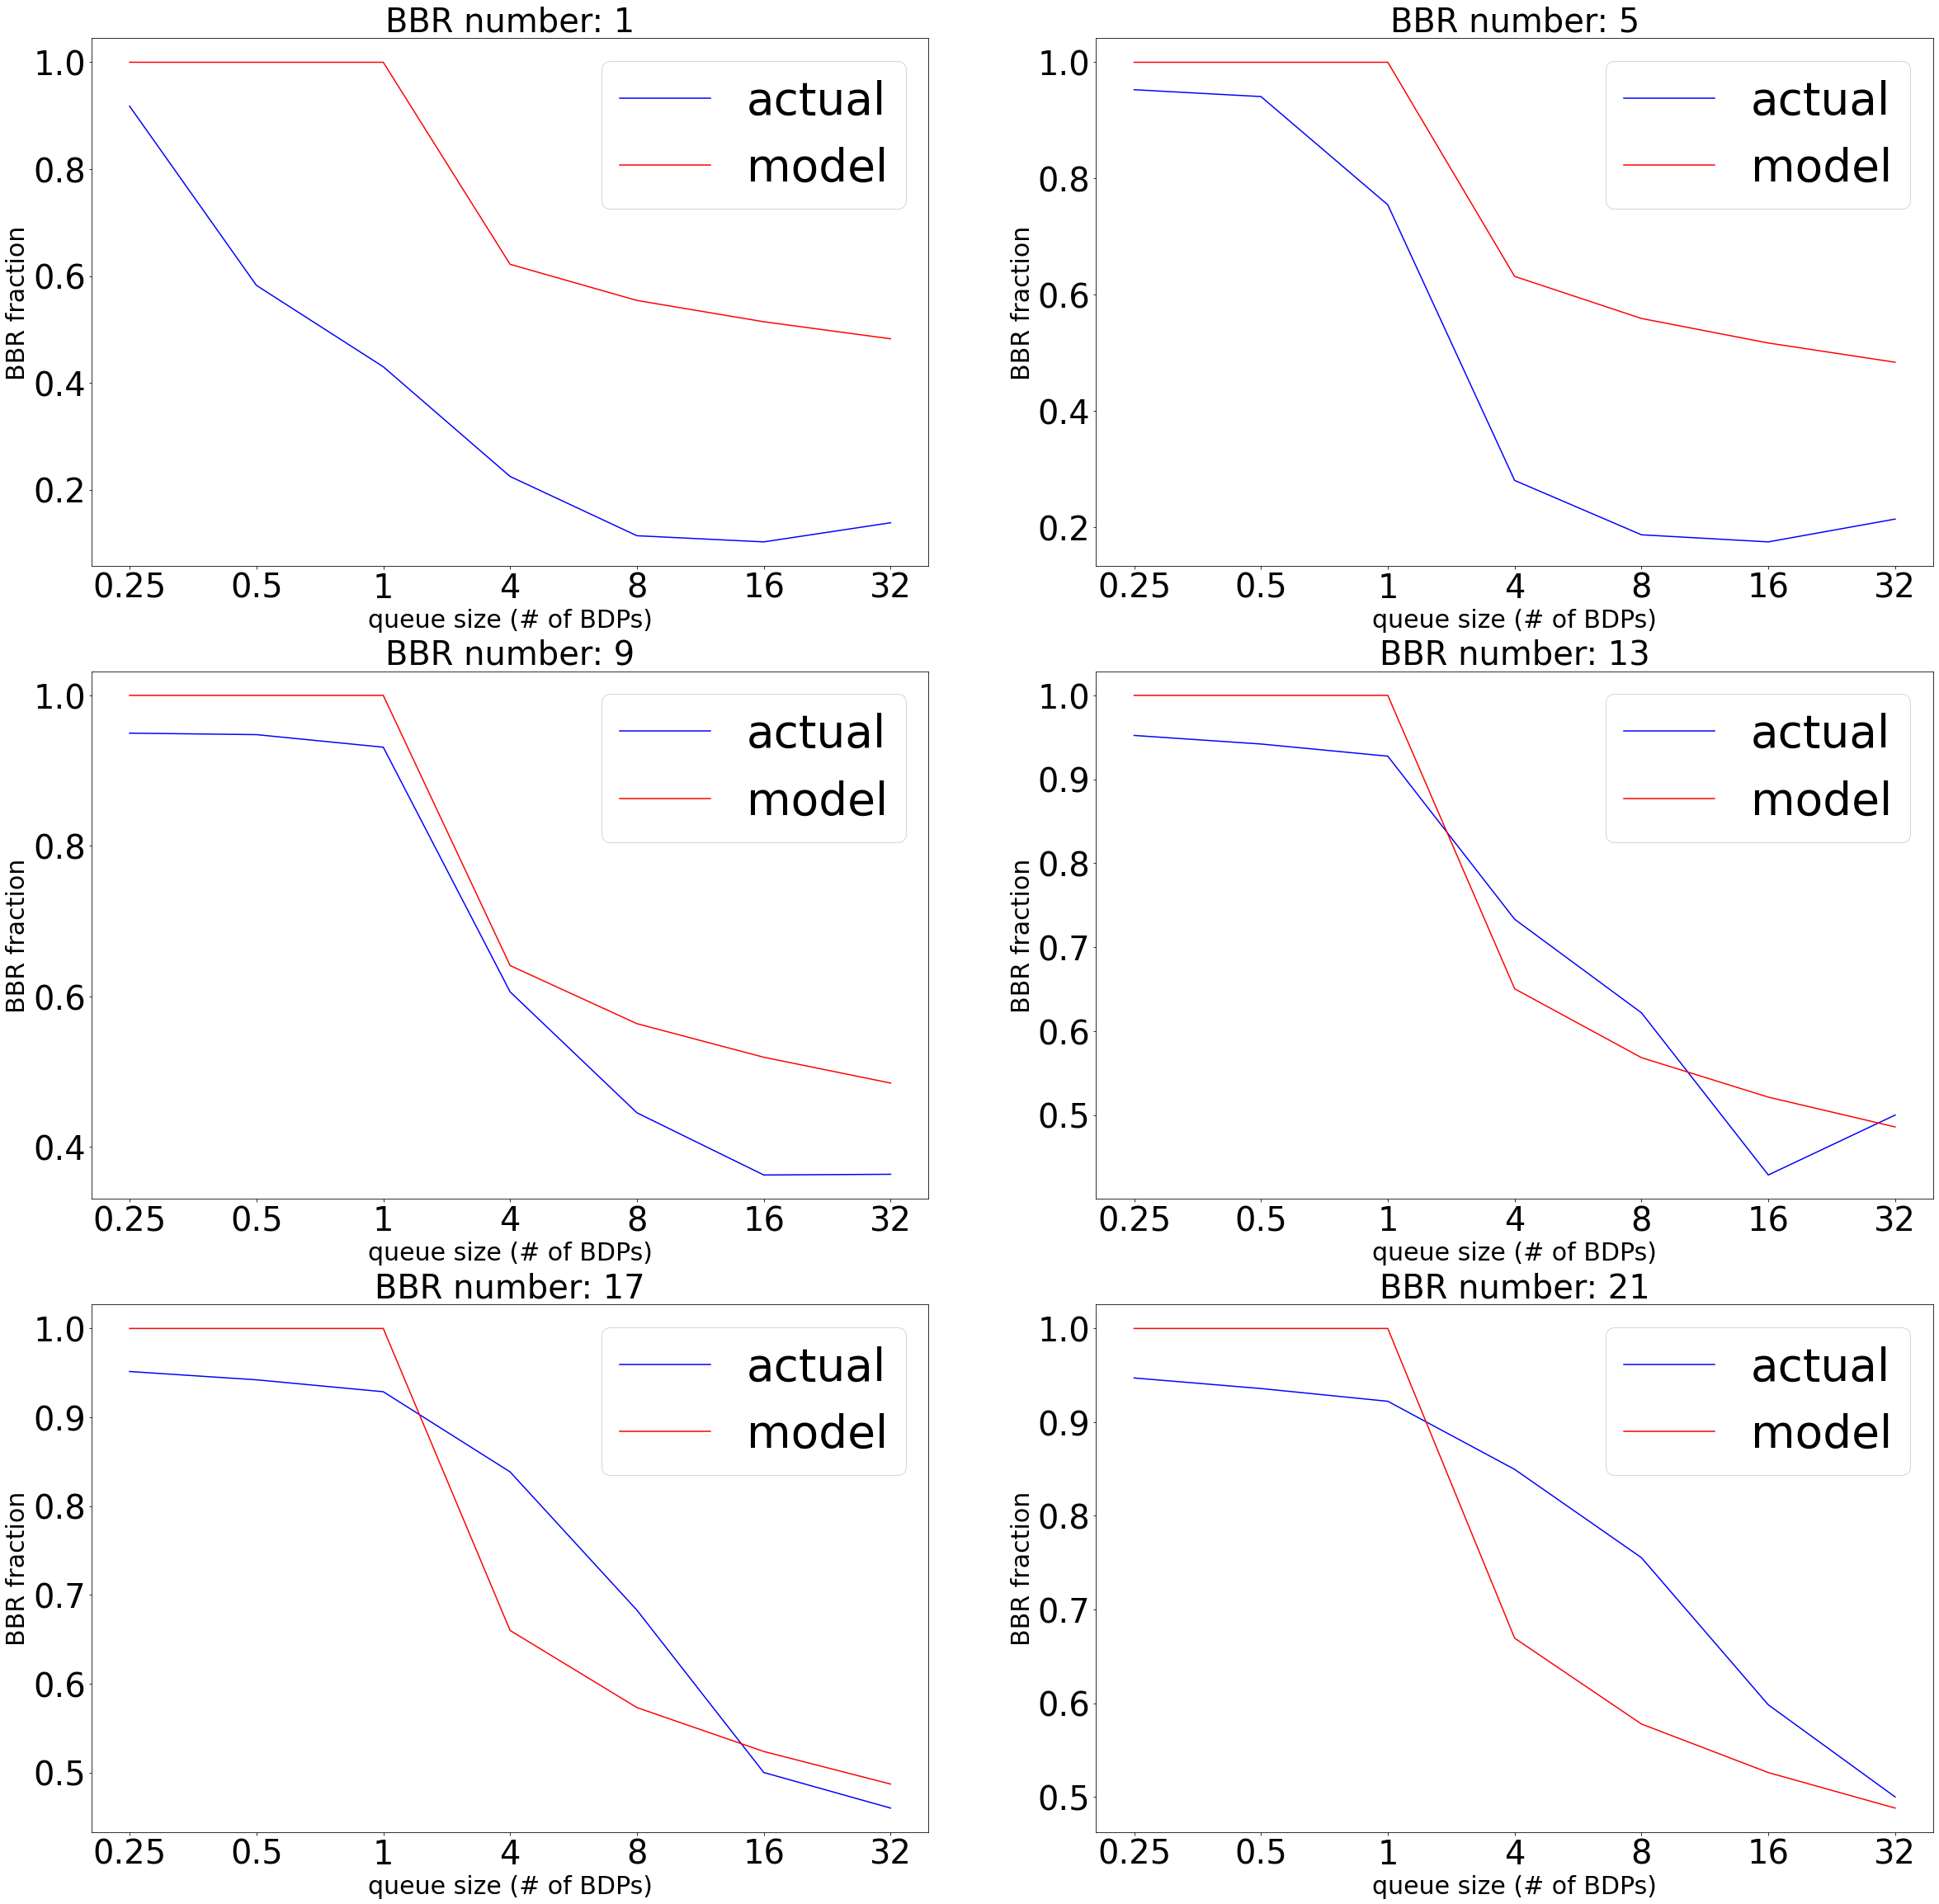

In [25]:
cubic_num = range(1, 34, 4)
bbr_num = range(1, 34, 4)
queues = [0.25, 0.5, 1, 4, 8, 16, 32]
loss_rate = [1, 2, 5, 10, 20, 50]
times = [60, 60, 60, 60, 60, 100, 200]

fig = plt.figure(1, figsize=(40, 40))
i = 1
for n in bbr_num[:6]:
    real_rates = get_rates(n, 1)
    model_rates = get_rates(n, 1, duration=1, isModel=True)
    ax = fig.add_subplot(int(f'32{i}'))
    i += 1
    ax.set_title(f'BBR number: {n}', fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=40)
    ax.xaxis.set_ticklabels([0] + queues)
    ax.set_xlabel('queue size (# of BDPs)', fontsize=30)
    ax.set_ylabel('BBR fraction', fontsize=30)
    ax.plot(real_rates, color='b', label='actual')
    ax.plot(model_rates, color='r', label='model')
    ax.legend()
plt.rcParams.update({'font.size': 40})
plt.show()

# EXP2
### collect all BBR bandwidths data

In [4]:
dataset = np.empty((0, 4))
for bn in bbr_num:
    for cn in cubic_num:
        for bdp in queues:
            b_rate, l_rate = get_bps(bdp, bn, cn, True), get_bps(bdp, bn, cn, False)
            dataset = np.append(dataset, np.array([[b_rate / (b_rate + l_rate), bdp, bn, cn]]), axis=0)


### interpolate for bad data
##### using the negative relation between queue size and bbr at most of the time

In [5]:
print(f'rows of bad data: {len(dataset[dataset[:, 0] == -1])}')
print(f'experiment failed rate: {len(dataset[dataset[:, 0] == -1]) / len(dataset)}')

rows of bad data: 0
experiment failed rate: 0.0


In [6]:
# in-place interpolation
def interpolate(subset, r_ind, bdp, bn, cn):
    if r_ind > 1:
        dy = subset[r_ind-1, 0] - subset[r_ind-2, 0]
        dx = subset[r_ind-1, 1] - subset[r_ind-2, 1]
        est = subset[r_ind-1, 0] + dy/dx * (subset[r_ind, 1]-subset[r_ind-1, 1])
    else:
        dy = subset[r_ind+1, 0] - subset[r_ind+2, 0]
        dx = subset[r_ind+1, 1] - subset[r_ind+2, 1]
        est = subset[r_ind+1, 0] + dy/dx * (subset[r_ind, 1]-subset[r_ind+1, 1])
#     print(subset[r_ind, 0], r_ind, dy, dx)
    dataset[(dataset[:, 1] == bdp) & (dataset[:, 2] == bn) & (dataset[:, 3] == cn), 0] = est
        

def intrp_helper(bn, cn):
    subset = dataset[(dataset[:, 2] == bn) & (dataset[:, 3] == cn)]
    # sort by queue
    subset = subset[subset[:, 1].argsort(axis=0)]

    for i in range(len(subset)):
        if subset[i, 0] == -1: interpolate(subset, i, subset[i, 1], bn, cn)

for cn in cubic_num:
    for bn in bbr_num:
        intrp_helper(bn, cn)
print(f'rows of bad data: {len(dataset[dataset[:, 0] == -1])}')

rows of bad data: 0


### plot data

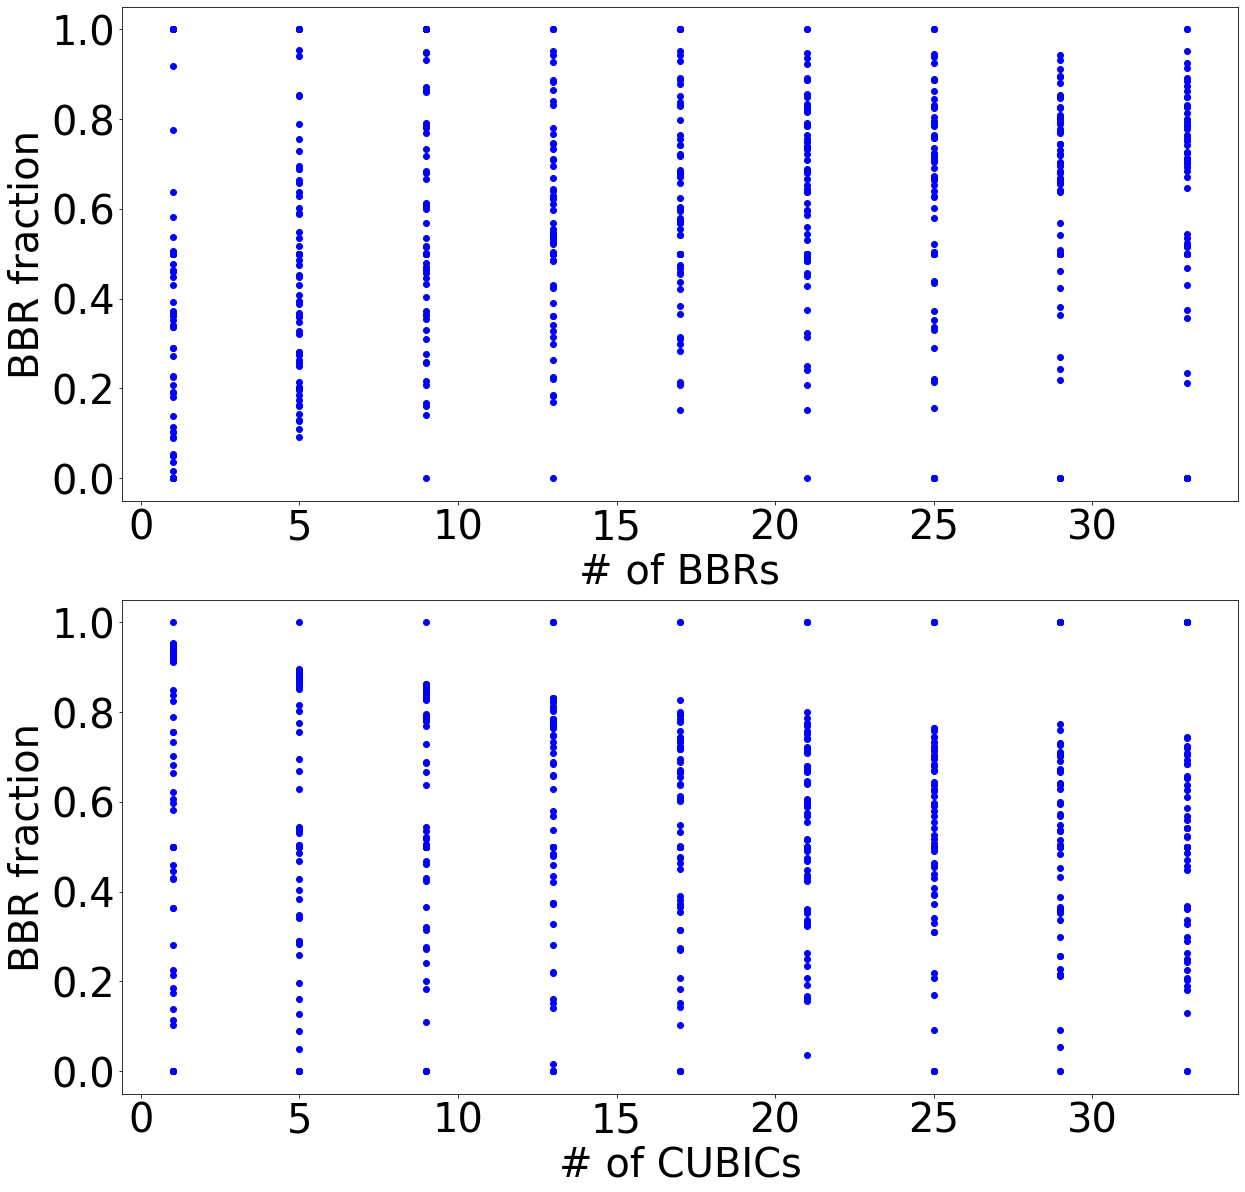

In [7]:
fig = plt.figure(1, figsize=(20, 20))
ax = fig.add_subplot(211)
ax.tick_params(axis='both', which='major', labelsize=40)
dataset = dataset[dataset[:, 2].argsort(axis=0)]
ax.set_xlabel('# of BBRs', fontsize=40)
ax.set_ylabel('BBR fraction', fontsize=40)
ax.scatter(dataset[:, 2], dataset[:, 0], color='b')


ax = fig.add_subplot(212)
ax.tick_params(axis='both', which='major', labelsize=40)
dataset = dataset[dataset[:, 3].argsort(axis=0)]
ax.set_xlabel('# of CUBICs', fontsize=40)
ax.set_ylabel('BBR fraction', fontsize=40)
ax.scatter(dataset[:, 3], dataset[:, 0], color='b')

# ax = fig.add_subplot(133)
# dataset = dataset[dataset[:, 1].argsort(axis=0)]
# ax.set_xlabel('queue size')
# ax.set_ylabel('BBR fraction')
# ax.scatter(dataset[:, 1], dataset[:, 0], color='b')

### Regression test

In [8]:
test = (dataset - dataset.mean(axis=0)) / dataset.std(axis=0) # standardize 

lrg = linear_model.OLS(test[:, 0], test[:, 1])
res = lrg.fit()
print(res.summary())

lrg = linear_model.OLS(test[:, 0], test[:, 2])
res = lrg.fit()
print(res.summary())

lrg = linear_model.OLS(test[:, 0], test[:, 3])
res = lrg.fit()
print(res.summary())

lrg = linear_model.OLS(test[:, 0], test[:, 1:4])
res = lrg.fit()
print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.190
Model:                            OLS   Adj. R-squared (uncentered):              0.188
Method:                 Least Squares   F-statistic:                              132.7
Date:                Sun, 12 Dec 2021   Prob (F-statistic):                    1.00e-27
Time:                        16:22:25   Log-Likelihood:                         -744.84
No. Observations:                 567   AIC:                                      1492.
Df Residuals:                     566   BIC:                                      1496.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Pearson Correlation

In [9]:
queue_cor=stats.pearsonr(dataset[:,0], dataset[:,1])
print("Queue Pearson Correlation: ",queue_cor[0]," Queue P-Valie: ",queue_cor[1])
bbr_cor=stats.pearsonr(dataset[:,0], dataset[:,2])
print("BBR Pearson Correlation: ",bbr_cor[0]," BBR P-Valie: ",bbr_cor[1])
cubic_cor=stats.pearsonr(dataset[:,0], dataset[:,3])
print("Cubic Pearson Correlation: ",cubic_cor[0]," Cubic P-Valie: ",cubic_cor[1])


Queue Pearson Correlation:  -0.43576654389808966  Queue P-Valie:  1.1131752777787344e-27
BBR Pearson Correlation:  0.2287551263726117  BBR P-Valie:  3.624297792915659e-08
Cubic Pearson Correlation:  -0.08099956516221957  Cubic P-Valie:  0.05389814068313497


# EXP3

In [26]:
bw = 10 # mb
rtt = 40 # ms
loss_num = (9, 13)
bbr_num = (9, 13)
bdp = 4
loss_rate = [1, 2, 5, 10, 20, 50]

l_dataset = np.empty((0, 4))
for l in loss_rate:
    for n in bbr_num:
        for m in loss_num:
            b_rate, l_rate = get_loss_bps(4, n, m, True, lr=l), get_loss_bps(4, n, m, False, lr=l)
            l_dataset = np.append(l_dataset, np.array([[b_rate / (b_rate + l_rate), l, n, m]]), axis=0)
print(l_dataset.shape)

(24, 4)


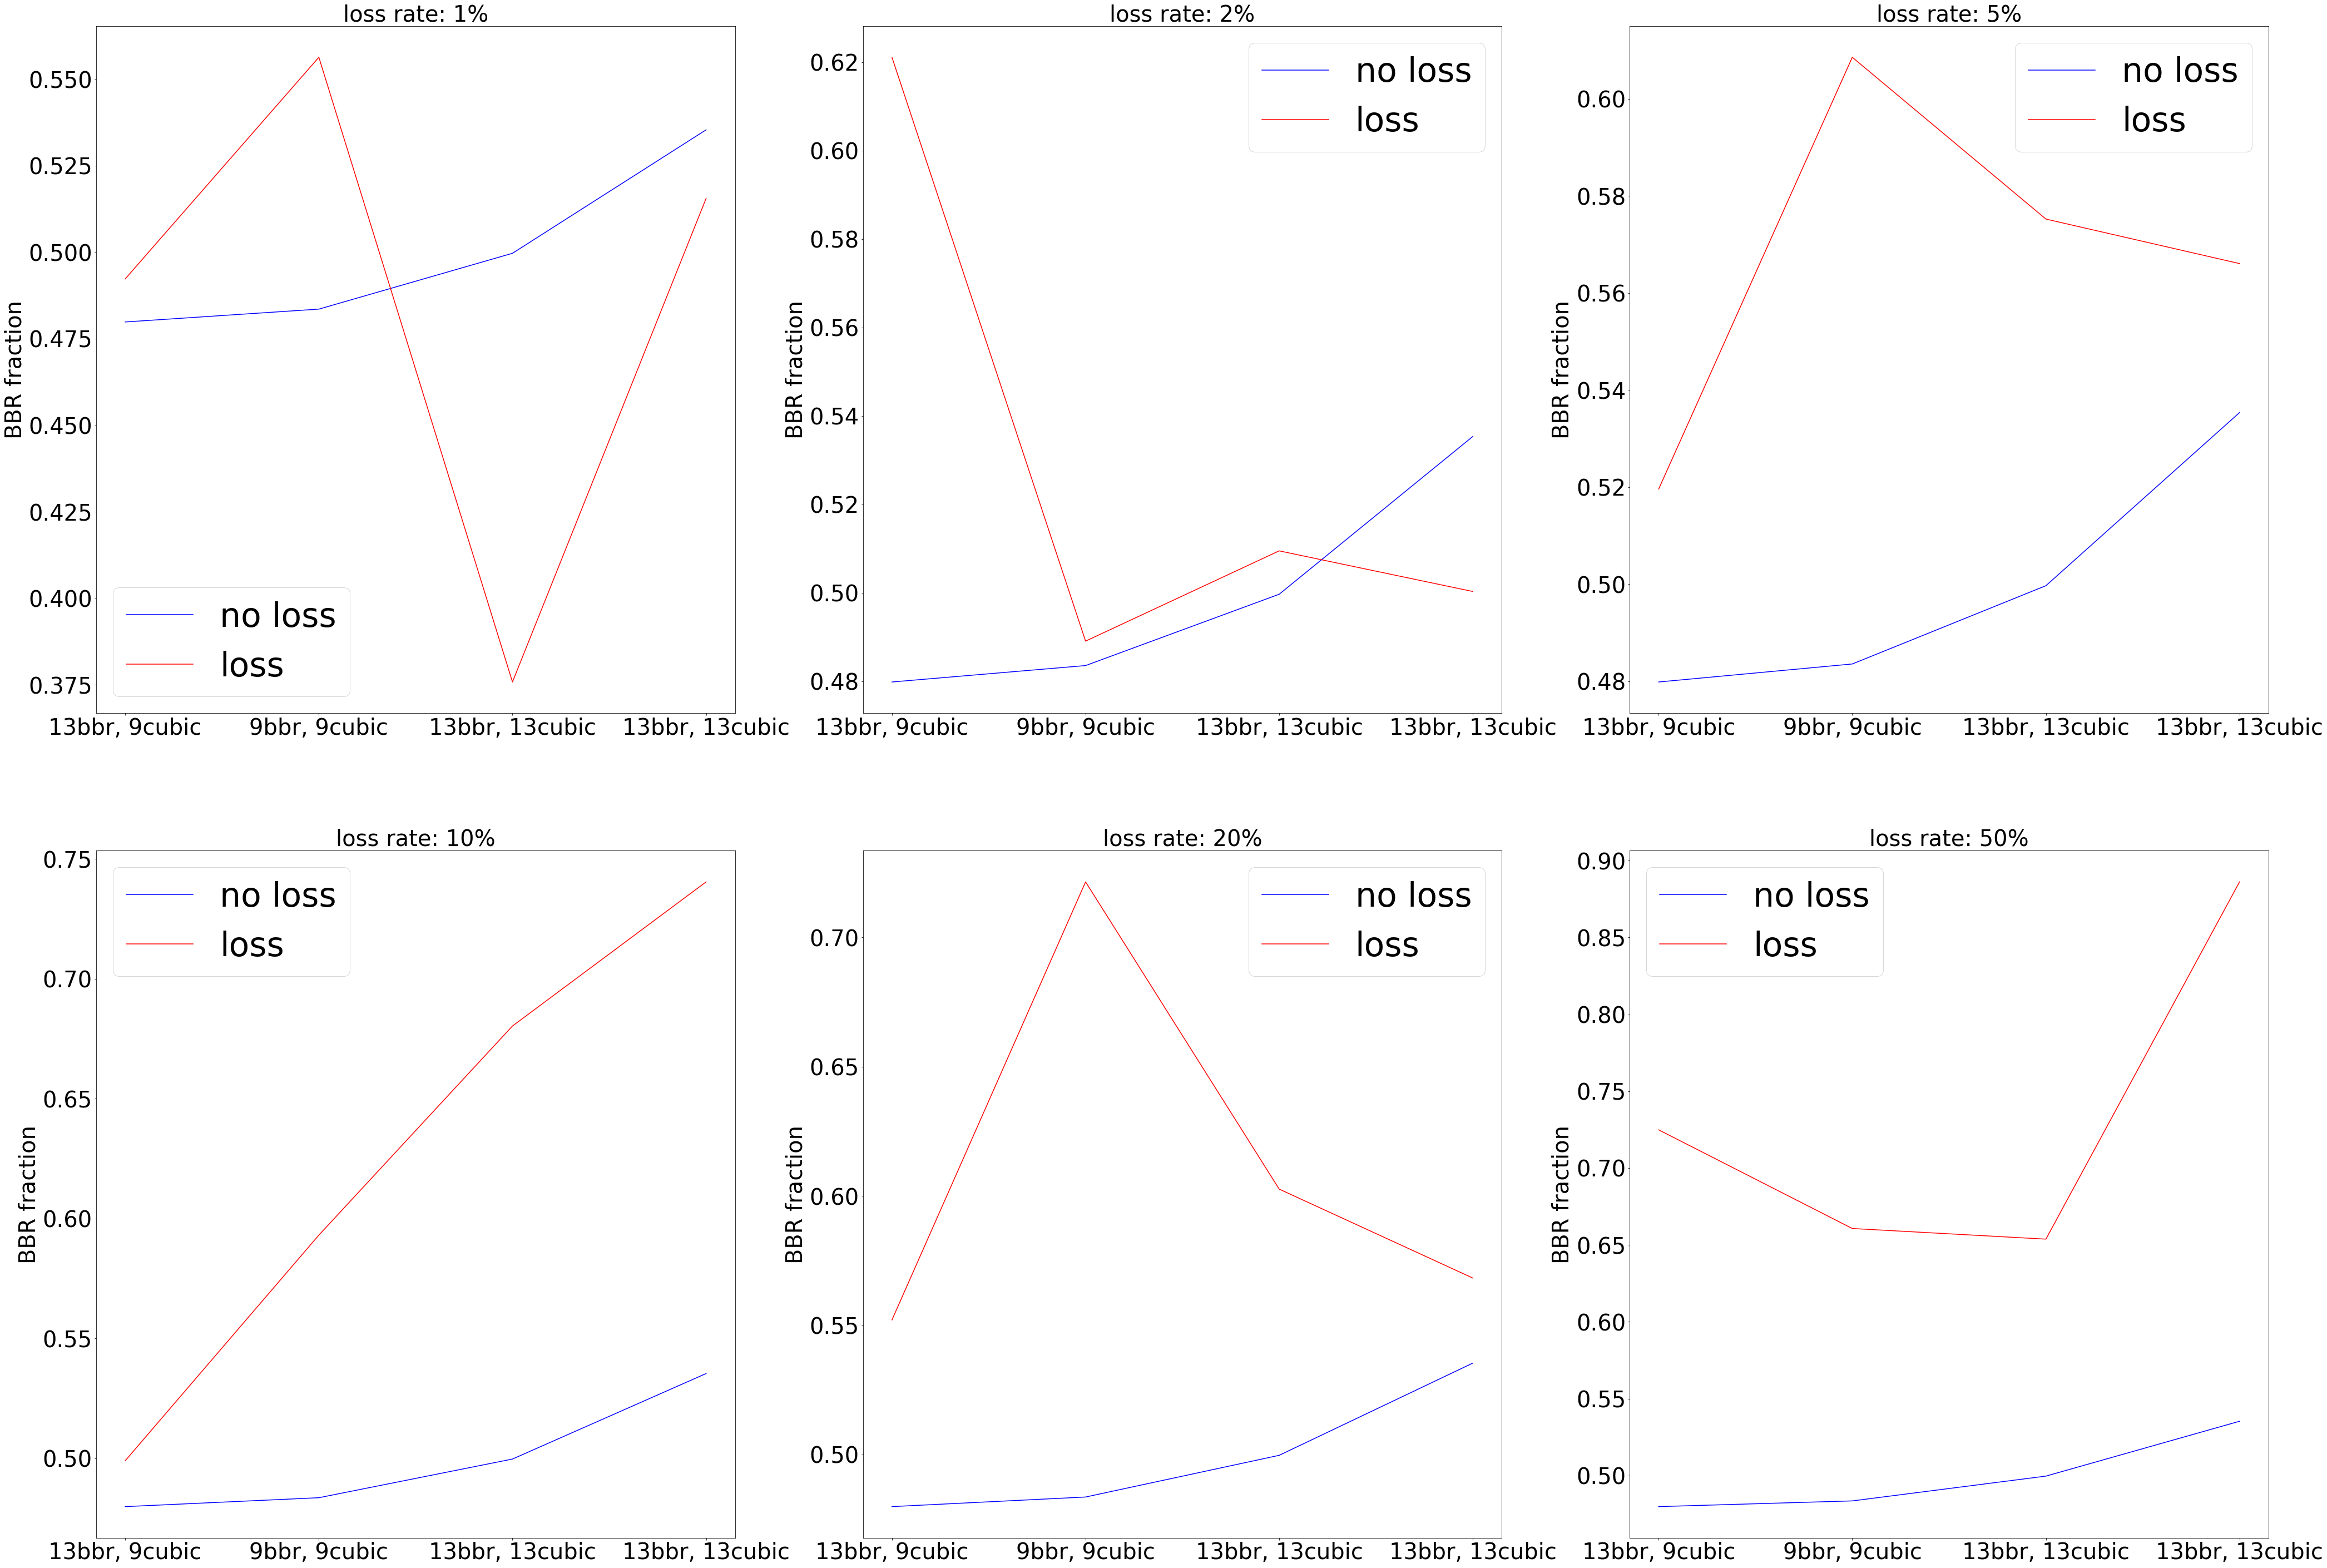

In [34]:
fig = plt.figure(1, figsize=(70, 50))
queues = [0.25, 0.5, 1, 4, 8, 16, 32]
i = 1
for l in loss_rate:
    l_bmask = l_dataset[:, 1] == l
    l_mask1 = l_bmask & (l_dataset[:, 2] == 9) & (l_dataset[:, 3] == 9)
    l_mask2 = l_bmask & (l_dataset[:, 2] == 9) & (l_dataset[:, 3] == 13) 
    l_mask3 = l_bmask & (l_dataset[:, 2] == 13) & (l_dataset[:, 3] == 9) 
    l_mask4 = l_bmask & (l_dataset[:, 2] == 13) & (l_dataset[:, 3] == 13) 

    bmask = dataset[:, 1] == 4
    mask1 = bmask & (dataset[:, 2] == 9) & (dataset[:, 3] == 9)
    mask2 = bmask & (dataset[:, 2] == 9) & (dataset[:, 3] == 13)
    mask3 = bmask & (dataset[:, 2] == 13) & (dataset[:, 3] == 9)
    mask4 = bmask & (dataset[:, 2] == 13) & (dataset[:, 3] == 13)
    l_masks = [l_mask2, l_mask4, l_mask1, l_mask3]
    r_masks = [mask2, mask4, mask1, mask3]
    l_rates = [l_dataset[m][0][0] for m in l_masks]
    r_rates = [dataset[m][0][0] for m in r_masks]

    ax = fig.add_subplot(int(f'23{i}'))
    ax.tick_params(axis='both', which='major', labelsize=40)
    i += 1
    ax.set_title(f'loss rate: {l}%', fontsize=40)
    ax.set_ylabel('BBR fraction', fontsize=40)
    ax.plot(r_rates, color='b', label='no loss')
    ax.plot(l_rates, color='r', label='loss')
    plt.xticks(range(4))
    ax.xaxis.set_ticklabels(['13bbr, 9cubic', '9bbr, 9cubic', '13bbr, 13cubic', '13bbr, 13cubic'], fontsize=40)
    ax.legend()
plt.show()
    